In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import style

In [128]:
def get_data(sample_num=2000):
    observed_r = np.random.uniform(low=0, high=5, size=(sample_num,)) # observed_r
    predicted_r = np.random.uniform(low=0, high=5, size=(sample_num,)) # predicted rating
    imputed_e = np.power((predicted_r - 0.5), 2)*0.3 ## e_hat_ui = 0.3*(r_ui - 0.5)^2
    
    observed_e = predicted_r - observed_r # e_ui
    propensities = np.random.uniform(low=0, high=1, size=(sample_num,)) # propensities for observed X_ui
   
    return observed_r, predicted_r, imputed_e, observed_e, propensities

In [129]:
get_data()

(array([3.99893536, 0.75014639, 2.0099915 , ..., 2.78644851, 3.70833774,
        4.6523895 ]),
 array([4.90156423, 4.65920669, 2.60252142, ..., 1.27168343, 0.3952222 ,
        1.2436698 ]),
 array([5.81213029e+00, 5.18970008e+00, 1.32617889e+00, ...,
        1.78648594e-01, 3.29351649e-03, 1.65913429e-01]),
 array([ 0.90262887,  3.9090603 ,  0.59252991, ..., -1.51476509,
        -3.31311555, -3.40871971]),
 array([0.99765816, 0.2543288 , 0.3729317 , ..., 0.65170097, 0.71713334,
        0.63352781]))

In [145]:
def SGD(predicted_r,
        imputed_e,
        observed_e,
        propensities,
        step_size=2,
        max_iter_count=2000):

    m = predicted_r.shape[0]
    var = 1
    theta = np.zeros(2)
    imputed_e = imputed_e.flatten()
    loss = 1
    iter_count = 0
    iter_list = []
    loss_list = []
    theta1 = []
    theta2 = []

    while loss > 0.01 and iter_count < max_iter_count:
        loss = 0
        theta = [1, 2]
        theta1.append(theta[0])
        theta2.append(theta[1])
        rand1 = np.random.randint(0, m, 1)

        gradient_w = 2 * predicted_r[rand1] * (
            2 * theta[1] - predicted_r[rand1]) * (
                (2 * predicted_r[rand1] * theta[1] - predicted_r[rand1]**2) *
                theta[0] + observed_e[rand1] - theta[1]**2) / propensities[rand1]

        gradient_y = 4 * (theta[1] - theta[0] * predicted_r[rand1]) * (
            theta[1]**2 - 2 * predicted_r[rand1] * theta[0] * theta[1] -
            observed_e[rand1] + theta[0] * predicted_r[rand1]**2) / propensities[rand1]
        
        gradient = [gradient_w, gradient_y]

        for i in range(len(theta)):
            theta[i] = theta[i] - step_size * gradient[i]
            
        h = np.power((predicted_r - theta[1]), 2) * theta[0]
        for i in range(m):
            every_loss = np.power((h[i] - observed_e[i]), 2) / propensities[i]
            loss = loss + every_loss

        print("iter_count: ", iter_count, "the loss:", loss, "the gradient:",
              gradient, "h: ", h)

        iter_list.append(iter_count)
        loss_list.append(loss)

        iter_count += 1

    plt.plot(iter_list, loss_list)
    plt.xlabel("iter")
    plt.ylabel("loss")
    plt.show()
    return theta1, theta2, theta, loss_list

iter_count:  0 the loss: 256598.75906084568 the gradient: [array([-21.27594267]), array([-21.45934902])] h:  [0.96337423 4.45538055 6.97168839 ... 7.91758226 2.75423361 0.40603248]
iter_count:  1 the loss: 256091.36338668191 the gradient: [array([-2.75502335]), array([1.67903169])] h:  [0.95706055 4.45691196 6.97101823 ... 7.91596586 2.7414747  0.40234095]
iter_count:  2 the loss: 253803.2881342708 the gradient: [array([48.57686298]), array([12.02508957])] h:  [0.95013601 4.43838773 6.94068159 ... 7.88113669 2.72399817 0.39897134]
iter_count:  3 the loss: 274007.19856294326 the gradient: [array([-312.34159577]), array([144.89982455])] h:  [0.95799952 4.65741752 7.2649634  ... 8.24427459 2.77763334 0.39627098]
iter_count:  4 the loss: 255210.97264187076 the gradient: [array([18.79890082]), array([10.99934565])] h:  [0.95317922 4.45123644 6.96090966 ... 7.90414343 2.73248807 0.40029486]
iter_count:  5 the loss: 255937.43030509932 the gradient: [array([4.03017824]), array([12.07037563])] 

iter_count:  65 the loss: 257010.68652066955 the gradient: [array([-21.36933538]), array([3.12601607])] h:  [0.9585579  4.46581811 6.98475636 ... 7.9315127  2.74609626 0.40290577]
iter_count:  66 the loss: 255486.8041638397 the gradient: [array([10.20615923]), array([2.73469292])] h:  [0.95561413 4.45158209 6.96254227 ... 7.90630201 2.73757324 0.40168586]
iter_count:  67 the loss: 364663.66866452596 the gradient: [array([-1277.76336636]), array([1347.06657853])] h:  [0.80263478 5.68598567 8.68110116 ... 9.79906855 2.60895186 0.28158039]
iter_count:  68 the loss: 410718.6351011059 the gradient: [array([-1535.60088372]), array([2003.97697804])] h:  [ 0.69810616  6.16126385  9.30503725 ... 10.47481992  2.4430626
  0.21726631]
iter_count:  69 the loss: 254146.05751540084 the gradient: [array([44.25958506]), array([20.37682239])] h:  [0.94892399 4.44382592 6.94808516 ... 7.88923635 2.72242932 0.39809217]
iter_count:  70 the loss: 257433.2674686415 the gradient: [array([-12.64392539]), array

iter_count:  128 the loss: 256461.50783858442 the gradient: [array([-8.71352752]), array([6.73249181])] h:  [0.95664144 4.46170241 6.97784148 ... 7.92352725 2.74143335 0.40193932]
iter_count:  129 the loss: 255104.50294010158 the gradient: [array([18.75349051]), array([4.39479747])] h:  [0.9544724  4.44847288 6.95746    ... 7.90046966 2.73468239 0.40113206]
iter_count:  130 the loss: 257935.07672354014 the gradient: [array([-14.07173881]), array([78.69829824])] h:  [0.9431141  4.4945747  7.0196863  ... 7.96837532 2.71909855 0.39307243]
iter_count:  131 the loss: 256095.96112346754 the gradient: [array([-11.01524226]), array([-22.09628101])] h:  [0.96251288 4.45054983 6.96421378 ... 7.90911706 2.75162499 0.40569792]
iter_count:  132 the loss: 254676.01997839962 the gradient: [array([12.85835347]), array([-39.19467003])] h:  [0.96356928 4.43273836 6.93860101 ... 7.88065929 2.75072818 0.40690751]
iter_count:  133 the loss: 255527.195458747 the gradient: [array([10.94542905]), array([7.336

iter_count:  194 the loss: 255290.94484208772 the gradient: [array([14.28527271]), array([2.71415611])] h:  [0.95522794 4.44975572 6.95968844 ... 7.9030621  2.7364622  0.40152444]
iter_count:  195 the loss: 256491.598517157 the gradient: [array([-20.19258073]), array([-24.807987])] h:  [0.96392817 4.45348401 6.96916479 ... 7.91484014 2.7550485  0.40641586]
iter_count:  196 the loss: 254266.88534186466 the gradient: [array([35.82189195]), array([3.10279228])] h:  [0.95309201 4.44032224 6.94488265 ... 7.88623511 2.73043215 0.40060935]
iter_count:  197 the loss: 256077.61576768645 the gradient: [array([-2.44504992]), array([1.74796639])] h:  [0.95701741 4.45680295 6.97083861 ... 7.91575935 2.74136692 0.40231974]
iter_count:  198 the loss: 256482.14568818052 the gradient: [array([-17.65821211]), array([-17.99627962])] h:  [0.96234628 4.45523524 6.97100176 ... 7.91667435 2.75208917 0.40544437]
iter_count:  199 the loss: 257291.3067509421 the gradient: [array([-33.29690897]), array([-14.5344

iter_count:  261 the loss: 255924.21717641698 the gradient: [array([0.25782519]), array([0.31824224])] h:  [0.95703851 4.45499508 6.96820012 ... 7.91281597 2.74109953 0.40239239]
iter_count:  262 the loss: 255360.43552331597 the gradient: [array([11.47107059]), array([-1.26196947])] h:  [0.95627418 4.44933317 6.959553   ... 7.90305492 2.73854847 0.40214144]
iter_count:  263 the loss: 256027.89975488136 the gradient: [array([-3.70375144]), array([-4.92121236])] h:  [0.95844346 4.45454766 6.96819375 ... 7.91300223 2.74392132 0.40321706]
iter_count:  264 the loss: 255345.59112236867 the gradient: [array([5.85091779]), array([-18.58878539])] h:  [0.96020396 4.44453007 6.95433001 ... 7.89776282 2.74582696 0.40456823]
iter_count:  265 the loss: 256434.66202858285 the gradient: [array([-7.43762526]), array([8.81105138])] h:  [0.9561128  4.46201205 6.97805046 ... 7.92368774 2.7403954  0.40162449]
iter_count:  266 the loss: 258399.5228825443 the gradient: [array([-48.60355724]), array([7.551301

iter_count:  327 the loss: 263120.4668978417 the gradient: [array([-150.95687755]), array([-7.7756585])] h:  [0.97311893 4.51889519 7.06923522 ... 8.02785075 2.78527131 0.40952035]
iter_count:  328 the loss: 252677.88657494768 the gradient: [array([44.73161901]), array([-69.57195961])] h:  [0.96644421 4.40585848 6.90052397 ... 7.83852793 2.75199633 0.40947872]
iter_count:  329 the loss: 255590.00379234497 the gradient: [array([2.65387719]), array([-13.00950152])] h:  [0.95941797 4.44830467 6.95949767 ... 7.90342553 2.74485655 0.4039882 ]
iter_count:  330 the loss: 255320.77354711827 the gradient: [array([-0.70596233]), array([-39.35500476])] h:  [0.96490948 4.43869124 6.94794034 ... 7.89127254 2.75451738 0.40748063]
iter_count:  331 the loss: 256295.43927676196 the gradient: [array([-7.78460327]), array([-0.59030415])] h:  [0.95798613 4.45819424 6.97332435 ... 7.91866842 2.74360519 0.40283139]
iter_count:  332 the loss: 258894.9634989988 the gradient: [array([-54.32725243]), array([20.

iter_count:  393 the loss: 253991.46788159895 the gradient: [array([55.62099553]), array([44.04981147])] h:  [0.94325003 4.44870747 6.9525998  ... 7.89349262 2.71154229 0.39466619]
iter_count:  394 the loss: 257868.257110115 the gradient: [array([-27.84537201]), array([35.57286269])] h:  [0.95282353 4.48245174 7.00646059 ... 7.9549561  2.73710921 0.39905051]
iter_count:  395 the loss: 255762.86547532442 the gradient: [array([3.30204031]), array([-0.60727655])] h:  [0.95692819 4.45324828 6.96559033 ... 7.90988656 2.74057144 0.40238728]
iter_count:  396 the loss: 257083.0682857326 the gradient: [array([-24.19791844]), array([-0.70821225])] h:  [0.95958041 4.46545603 6.98469858 ... 7.93158898 2.74814399 0.40350705]
iter_count:  397 the loss: 256192.13566940842 the gradient: [array([-6.12765923]), array([-2.02329001])] h:  [0.95810812 4.45685087 6.97141284 ... 7.91655072 2.74362578 0.40294665]
iter_count:  398 the loss: 255189.02560472593 the gradient: [array([6.69708876]), array([-25.7041

iter_count:  458 the loss: 249928.7894505453 the gradient: [array([-66.4199385]), array([-625.77175174])] h:  [1.09067984 4.22259193 6.68586757 ... 7.61494521 2.97201689 0.48898135]
iter_count:  459 the loss: 253891.69107127644 the gradient: [array([16.06222308]), array([-78.66451859])] h:  [0.97101709 4.41472789 6.91561702 ... 7.85600773 2.76294108 0.41182318]
iter_count:  460 the loss: 259677.79722157834 the gradient: [array([-45.56806949]), array([90.74367324])] h:  [0.94373329 4.51383953 7.04817347 ... 8.00026557 2.72366435 0.39279398]
iter_count:  461 the loss: 255491.377941889 the gradient: [array([11.88408842]), array([7.89499994])] h:  [0.95444568 4.45301069 6.96409449 ... 7.90787429 2.73540724 0.40096499]
iter_count:  462 the loss: 254850.23733184912 the gradient: [array([24.13647974]), array([4.60621964])] h:  [0.9539164  4.44616283 6.95381914 ... 7.89632753 2.73313772 0.40088899]
iter_count:  463 the loss: 253632.88652691554 the gradient: [array([17.75634046]), array([-89.94

iter_count:  525 the loss: 255519.42496957918 the gradient: [array([8.1458895]), array([-1.28450346])] h:  [0.95659693 4.45080485 6.96185795 ... 7.90567319 2.73946759 0.40227817]
iter_count:  526 the loss: 255817.00240636957 the gradient: [array([2.41079851]), array([0.0826015])] h:  [0.95687855 4.45393645 6.96657546 ... 7.91097978 2.74058738 0.40233564]
iter_count:  527 the loss: 259498.51476948435 the gradient: [array([-57.72637856]), array([46.11382893])] h:  [0.953597   4.50029264 7.03294433 ... 7.98463349 2.74176327 0.39890314]
iter_count:  528 the loss: 254149.19083371476 the gradient: [array([43.70217357]), array([18.94119489])] h:  [0.94925624 4.44347078 6.94771899 ... 7.88887335 2.72305449 0.39829525]
iter_count:  529 the loss: 260081.9258614063 the gradient: [array([-62.16206439]), array([67.37021343])] h:  [0.94985684 4.51133051 7.0473623  ... 8.00021225 2.73591422 0.39638963]
iter_count:  530 the loss: 256313.41444063565 the gradient: [array([-9.00550522]), array([-3.049199

iter_count:  591 the loss: 255345.64952989042 the gradient: [array([12.63353963]), array([1.22738477])] h:  [0.95567643 4.44986487 6.96005563 ... 7.90353389 2.73740648 0.4017792 ]
iter_count:  592 the loss: 255263.9499037951 the gradient: [array([13.47586653]), array([-1.28889038])] h:  [0.95608751 4.44842879 6.95814196 ... 7.90145358 2.73800772 0.40206414]
iter_count:  593 the loss: 253675.28266235342 the gradient: [array([14.50780187]), array([-97.01526465])] h:  [0.97478587 4.40771214 6.90705175 ... 7.84695398 2.76947122 0.4142444 ]
iter_count:  594 the loss: 255581.53985170927 the gradient: [array([7.28294685]), array([-0.02417194])] h:  [0.95643311 4.45172087 6.9631241  ... 7.90706448 2.73928713 0.40215311]
iter_count:  595 the loss: 257358.92349473562 the gradient: [array([-28.1327068]), array([4.4618371])] h:  [0.95894282 4.46939765 6.99017767 ... 7.93761938 2.74750611 0.40300783]
iter_count:  596 the loss: 257222.28959833202 the gradient: [array([-25.54953468]), array([3.737229

iter_count:  656 the loss: 255641.5241383235 the gradient: [array([6.55168614]), array([1.48836053])] h:  [0.95620737 4.45268474 6.96443169 ... 7.90849352 2.73898709 0.40199078]
iter_count:  657 the loss: 254899.62492782917 the gradient: [array([19.86607956]), array([-4.85518968])] h:  [0.95617236 4.44408006 6.9518107  ... 7.89439539 2.73743452 0.40225867]
iter_count:  658 the loss: 255563.93484373408 the gradient: [array([9.77747341]), array([6.16742987])] h:  [0.95498443 4.45322109 6.96465189 ... 7.90857094 2.73655543 0.40126829]
iter_count:  659 the loss: 257258.88375225305 the gradient: [array([-25.84346678]), array([5.08056003])] h:  [0.9586026  4.46863929 6.9889095  ... 7.93615642 2.74667355 0.40283718]
iter_count:  660 the loss: 279139.9460493095 the gradient: [array([-211.98254829]), array([638.995303])] h:  [0.85390476 4.82904418 7.46460267 ... 8.45186561 2.5874758  0.33235163]
iter_count:  661 the loss: 256887.39651649 the gradient: [array([-22.60107976]), array([-7.85704662]

iter_count:  722 the loss: 246334.7800247007 the gradient: [array([113.2338221]), array([-282.7399458])] h:  [1.00177396 4.28731729 6.74251684 ... 7.66676418 2.80359065 0.43414343]
iter_count:  723 the loss: 275687.3189553254 the gradient: [array([-186.19284894]), array([544.90258803])] h:  [0.86936707 4.77525454 7.39401566 ... 8.3754645  2.61154421 0.34253806]
iter_count:  724 the loss: 257841.5633024837 the gradient: [array([-10.84040584]), array([82.3978276])] h:  [0.94209109 4.49469376 7.01938243 ... 7.96789365 2.71700075 0.39248167]
iter_count:  725 the loss: 241362.12778636313 the gradient: [array([222.78652211]), array([-283.91863911])] h:  [0.99090558 4.23933068 6.66720286 ... 7.58116892 2.77291293 0.42948554]
iter_count:  726 the loss: 256002.87231421215 the gradient: [array([-1.4556338]), array([0.10020562])] h:  [0.95724517 4.45566639 6.96927899 ... 7.91404915 2.74164143 0.40248901]
iter_count:  727 the loss: 254980.86957272506 the gradient: [array([-11.36655667]), array([-9

iter_count:  788 the loss: 259090.49381923978 the gradient: [array([-51.06387725]), array([41.21682723])] h:  [0.95392409 4.49522947 7.02568266 ... 7.97657087 2.74157261 0.39925908]
iter_count:  789 the loss: 255712.60562194517 the gradient: [array([-5.65870883]), array([-29.83674047])] h:  [0.9635173  4.44490315 6.95640263 ... 7.90053199 2.75272131 0.40646751]
iter_count:  790 the loss: 257301.0157410849 the gradient: [array([-30.25210012]), array([-5.13318961])] h:  [0.96102865 4.46627964 6.98657408 ... 7.93388257 2.75127371 0.40431413]
iter_count:  791 the loss: 257148.98589756637 the gradient: [array([-22.82829617]), array([7.20342533])] h:  [0.95789825 4.46819384 6.98793123 ... 7.934967   2.74514321 0.40244634]
iter_count:  792 the loss: 255835.9028279852 the gradient: [array([2.70238855]), array([2.07602979])] h:  [0.95646075 4.45464786 6.96742446 ... 7.91187028 2.73984757 0.4020711 ]
iter_count:  793 the loss: 256551.10559543365 the gradient: [array([-10.83056915]), array([5.995

iter_count:  854 the loss: 255928.08771517983 the gradient: [array([-0.47984339]), array([-1.59242468])] h:  [0.957483   4.45451714 6.9677054  ... 7.91232473 2.74193449 0.40266453]
iter_count:  855 the loss: 240949.27117167256 the gradient: [array([187.08013186]), array([-439.39722198])] h:  [1.02548061 4.191511   6.61210618 ... 7.52412379 2.83466455 0.45151517]
iter_count:  856 the loss: 258941.80369945892 the gradient: [array([-63.5711563]), array([-3.25093826])] h:  [0.96385026 4.48191544 7.01078236 ... 7.96130331 2.75978565 0.40541672]
iter_count:  857 the loss: 256272.88089510484 the gradient: [array([-7.46614606]), array([-1.02883586])] h:  [0.95804153 4.45786713 6.97287076 ... 7.91816955 2.74366321 0.40287425]
iter_count:  858 the loss: 255581.53985170927 the gradient: [array([7.28294685]), array([-0.02417194])] h:  [0.95643311 4.45172087 6.9631241  ... 7.90706448 2.73928713 0.40215311]
iter_count:  859 the loss: 253486.18004348807 the gradient: [array([54.06001167]), array([8.6

iter_count:  922 the loss: 256138.19843997678 the gradient: [array([-3.70235348]), array([1.7595697])] h:  [0.95713543 4.45736807 6.97172098 ... 7.91676089 2.74170766 0.40236884]
iter_count:  923 the loss: 259642.92943478323 the gradient: [array([-92.98653718]), array([-46.23191226])] h:  [0.97517711 4.47672481 7.00839334 ... 7.96018957 2.78223874 0.41212719]
iter_count:  924 the loss: 257360.6612556983 the gradient: [array([-29.55783442]), array([0.45130159])] h:  [0.95986595 4.46833462 6.98904726 ... 7.93648425 2.74922832 0.40357525]
iter_count:  925 the loss: 256494.3242657454 the gradient: [array([-9.22873719]), array([7.21606413])] h:  [0.95659604 4.46213647 6.97845628 ... 7.92420749 2.74141426 0.40189867]
iter_count:  926 the loss: 256909.0512570985 the gradient: [array([-12.75201908]), array([21.90912301])] h:  [0.95405846 4.46992183 6.98868406 ... 7.93527792 2.73751192 0.40017784]
iter_count:  927 the loss: 256506.42881387976 the gradient: [array([-22.60370018]), array([-30.942

iter_count:  986 the loss: 261316.98950561124 the gradient: [array([-82.35606384]), array([81.47904014])] h:  [0.94900096 4.52641048 7.06903706 ... 8.02429218 2.73671575 0.3954015 ]
iter_count:  987 the loss: 255166.78887480768 the gradient: [array([14.93963952]), array([-2.93804991])] h:  [0.95626964 4.44708171 6.95625277 ... 7.89936907 2.73815175 0.40221421]
iter_count:  988 the loss: 258749.41221463858 the gradient: [array([-62.17490541]), array([-10.6643546])] h:  [0.96517714 4.47814571 7.00587247 ... 7.95600309 2.76187389 0.40630794]
iter_count:  989 the loss: 263966.9449051287 the gradient: [array([-19.97548139]), array([392.71249671])] h:  [0.88358886 4.63152927 7.19142211 ... 8.15157214 2.61799574 0.35486671]
iter_count:  990 the loss: 261144.83005619634 the gradient: [array([-90.76048728]), array([48.09851913])] h:  [0.95633907 4.51592093 7.0571029  ... 8.01198723 2.75010718 0.39996111]
iter_count:  991 the loss: 257675.5026470105 the gradient: [array([-22.10197982]), array([4

iter_count:  1052 the loss: 256482.60867856923 the gradient: [array([-23.49159161]), array([-34.98755288])] h:  [0.96624811 4.4506491  6.96607849 ... 7.91171166 2.7593404  0.40785035]
iter_count:  1053 the loss: 257828.85202658657 the gradient: [array([-31.98957644]), array([21.36865662])] h:  [0.95599735 4.4782808  7.00182497 ... 7.95021874 2.74295083 0.40101526]
iter_count:  1054 the loss: 255556.66989933015 the gradient: [array([-14.57495446]), array([-65.68535518])] h:  [0.97143476 4.43374333 6.94368215 ... 7.88740894 2.76709668 0.411419  ]
iter_count:  1055 the loss: 262317.63241745706 the gradient: [array([-78.27598023]), array([148.932645])] h:  [0.9354719  4.55343289 7.10222375 ... 8.05944773 2.71325375 0.38677284]
iter_count:  1056 the loss: 259193.87713746037 the gradient: [array([-52.57346685]), array([42.96927804])] h:  [0.95372414 4.49664976 7.02766941 ... 7.97876147 2.74140251 0.39909702]
iter_count:  1057 the loss: 257004.71806776713 the gradient: [array([-18.55709887]),

iter_count:  1120 the loss: 255774.75441325788 the gradient: [array([-5.26686938]), array([-24.8882382])] h:  [0.96250809 4.44681641 6.95874142 ... 7.90300535 2.75097131 0.4058207 ]
iter_count:  1121 the loss: 256814.8089024226 the gradient: [array([-16.58340748]), array([5.20344983])] h:  [0.95769314 4.46456394 6.98251941 ... 7.9288957  2.74409592 0.40244951]
iter_count:  1122 the loss: 250308.94617361994 the gradient: [array([71.54583936]), array([-141.43362766])] h:  [0.97795192 4.3640236  6.84442042 ... 7.77742584 2.76836019 0.41757869]
iter_count:  1123 the loss: 253314.10262197998 the gradient: [array([32.31683835]), array([-66.49837492])] h:  [0.9670458  4.41264195 6.91074259 ... 7.85002245 2.75440957 0.40959649]
iter_count:  1124 the loss: 257786.18981293042 the gradient: [array([-55.67400018]), array([-49.68717735])] h:  [0.97225518 4.45871152 6.98065315 ... 7.92881032 2.773107   0.41104778]
iter_count:  1125 the loss: 259452.83192238276 the gradient: [array([-43.22805891]), a

iter_count:  1184 the loss: 252193.54500057347 the gradient: [array([51.86330743]), array([-78.96348388])] h:  [0.96759382 4.39877218 6.89066198 ... 7.82767027 2.75313249 0.41038464]
iter_count:  1185 the loss: 257841.5633024837 the gradient: [array([-10.84040584]), array([82.3978276])] h:  [0.94209109 4.49469376 7.01938243 ... 7.96789365 2.71700075 0.39248167]
iter_count:  1186 the loss: 257193.06819337362 the gradient: [array([-17.79273598]), array([24.34484916])] h:  [0.95406245 4.47320328 6.99349172 ... 7.94064667 2.73808321 0.40007084]
iter_count:  1187 the loss: 269581.71907125134 the gradient: [array([-195.8809228]), array([222.35908521])] h:  [0.93201758 4.63844868 7.22490328 ... 8.19589117 2.72040269 0.38206552]
iter_count:  1188 the loss: 255928.08771517983 the gradient: [array([-0.47984339]), array([-1.59242468])] h:  [0.957483   4.45451714 6.9677054  ... 7.91232473 2.74193449 0.40266453]
iter_count:  1189 the loss: 255211.41507320784 the gradient: [array([14.87714323]), arr

iter_count:  1252 the loss: 263094.04735881044 the gradient: [array([-100.74484087]), array([130.35355952])] h:  [0.94117697 4.55561014 7.10809768 ... 8.06680552 2.72546454 0.38996372]
iter_count:  1253 the loss: 256072.604697374 the gradient: [array([-6.10149352]), array([-9.18878841])] h:  [0.95950931 4.45381336 6.9676101  ... 7.91249708 2.74599362 0.40385609]
iter_count:  1254 the loss: 261903.2278519757 the gradient: [array([-73.86217688]), array([138.01926272])] h:  [0.9371818  4.5467662  7.09327751 ... 8.04970136 2.71567443 0.38796679]
iter_count:  1255 the loss: 256026.512265373 the gradient: [array([-2.21045842]), array([-0.6626149])] h:  [0.95746671 4.45568058 6.96940216 ... 7.91421719 2.742101   0.40261619]
iter_count:  1256 the loss: 255628.64742149654 the gradient: [array([1.44859905]), array([-14.17373519])] h:  [0.95976172 4.44834988 6.95972245 ... 7.90372378 2.74557325 0.40418491]
iter_count:  1257 the loss: 250812.35910811878 the gradient: [array([167.20527902]), array(

iter_count:  1318 the loss: 240625.40816342022 the gradient: [array([217.91916255]), array([-356.85683311])] h:  [1.00581656 4.21177943 6.63331078 ... 7.54525974 2.79837668 0.43920904]
iter_count:  1319 the loss: 426079.3183612553 the gradient: [array([-642.51795508]), array([3774.24190548])] h:  [ 0.38428563  6.58843059  9.68816296 ... 10.83265855  1.7389208
  0.07027082]
iter_count:  1320 the loss: 255920.7414554814 the gradient: [array([-3.1711743]), array([-9.87372369])] h:  [0.95936251 4.45221995 6.96520802 ... 7.90979455 2.74541645 0.40382488]
iter_count:  1321 the loss: 260340.70329155686 the gradient: [array([-60.99816812]), array([85.49014499])] h:  [0.94620776 4.51853229 7.05619972 ... 8.00957111 2.72958886 0.39405862]
iter_count:  1322 the loss: 256739.39610197677 the gradient: [array([-19.75850115]), array([-8.53753744])] h:  [0.96069112 4.46016757 6.97746436 ... 7.9236636  2.74952534 0.40432439]
iter_count:  1323 the loss: 256026.512265373 the gradient: [array([-2.21045842

iter_count:  1385 the loss: 257558.55161341684 the gradient: [array([-26.36167596]), array([21.46948188])] h:  [0.95544131 4.47581122 6.99795039 ... 7.94581562 2.74137861 0.40077751]
iter_count:  1386 the loss: 256843.48272707532 the gradient: [array([-32.8689393]), array([-40.40667344])] h:  [0.96821999 4.45252182 6.9697292  ... 7.91605867 2.76372633 0.40892583]
iter_count:  1387 the loss: 231500.8661518992 the gradient: [array([388.72065136]), array([-497.24088612])] h:  [1.01580733 4.08243384 6.44740689 ... 7.33875768 2.7953468  0.44981168]
iter_count:  1388 the loss: 257422.92621154917 the gradient: [array([-29.25341443]), array([5.05742927])] h:  [0.95893317 4.47014935 6.99127428 ... 7.93884258 2.74761542 0.40297713]
iter_count:  1389 the loss: 251590.51327652845 the gradient: [array([57.56836916]), array([-100.44677812])] h:  [0.97125658 4.38727122 6.87547189 ... 7.81120275 2.75866489 0.41289766]
iter_count:  1390 the loss: 259679.16802818325 the gradient: [array([-9.87948167]), 

iter_count:  1452 the loss: 258582.71694239439 the gradient: [array([-57.74311923]), array([-7.83091826])] h:  [0.9641939  4.47737583 7.00429082 ... 7.9541017  2.75971326 0.40576689]
iter_count:  1453 the loss: 254180.6294356216 the gradient: [array([4.00718775]), array([-96.50881157])] h:  [0.9757109  4.41255996 6.91458141 ... 7.85548957 2.77221494 0.4146148 ]
iter_count:  1454 the loss: 249187.6126297514 the gradient: [array([99.24688147]), array([-130.14262883])] h:  [0.97300568 4.35653636 6.83119557 ... 7.76198517 2.75690417 0.41496491]
iter_count:  1455 the loss: 253522.88098023424 the gradient: [array([28.94428397]), array([-63.41788286])] h:  [0.966768   4.41542759 6.91469848 ... 7.85440256 2.75432042 0.40934137]
iter_count:  1456 the loss: 259204.26719851367 the gradient: [array([-73.98188385]), array([-17.58581205])] h:  [0.96767596 4.48045893 7.01041395 ... 7.96141786 2.76742555 0.40767135]
iter_count:  1457 the loss: 265850.7317743066 the gradient: [array([-157.88764182]), a

iter_count:  1519 the loss: 257868.257110115 the gradient: [array([-27.84537201]), array([35.57286269])] h:  [0.95282353 4.48245174 7.00646059 ... 7.9549561  2.73710921 0.39905051]
iter_count:  1520 the loss: 255996.76265031038 the gradient: [array([-2.64115833]), array([-3.71719117])] h:  [0.9581059  4.45458279 6.96808932 ... 7.91283917 2.74323096 0.40302132]
iter_count:  1521 the loss: 255077.3618324046 the gradient: [array([22.7734316]), array([14.4535632])] h:  [0.95212621 4.45091965 6.95995818 ... 7.90293577 2.73025965 0.39969908]
iter_count:  1522 the loss: 256224.80648500886 the gradient: [array([-4.66617968]), array([4.19387291])] h:  [0.95675126 4.45882576 6.97367861 ... 7.91889395 2.7411655  0.40209875]
iter_count:  1523 the loss: 258925.97232502766 the gradient: [array([-58.44505213]), array([10.50450518])] h:  [0.96065311 4.48547409 7.01451686 ... 7.96503303 2.75379935 0.40345576]
iter_count:  1524 the loss: 256413.05079991493 the gradient: [array([-13.06095901]), array([-8

iter_count:  1584 the loss: 255936.76500632375 the gradient: [array([-0.13726095]), array([-0.07042116])] h:  [0.95715237 4.45500702 6.96827023 ... 7.91290994 2.74133653 0.4024576 ]
iter_count:  1585 the loss: 253762.7607364713 the gradient: [array([49.1116892]), array([11.10478787])] h:  [0.95026392 4.4377624  6.93982487 ... 7.8801977  2.72415481 0.39906588]
iter_count:  1586 the loss: 255562.43111313554 the gradient: [array([8.21653352]), array([1.5339206])] h:  [0.95603916 4.45196217 6.96329549 ... 7.90720163 2.73851571 0.40191804]
iter_count:  1587 the loss: 249352.43068570804 the gradient: [array([141.5860833]), array([9.44432922])] h:  [0.941753   4.39583057 6.87446797 ... 7.80604512 2.69938074 0.39556469]
iter_count:  1588 the loss: 256157.53707796198 the gradient: [array([-4.52919431]), array([0.52756977])] h:  [0.95745568 4.45721615 6.97164646 ... 7.91672177 2.74234239 0.40255845]
iter_count:  1589 the loss: 256268.40882584392 the gradient: [array([-13.63887168]), array([-19.2

iter_count:  1650 the loss: 227495.15188856068 the gradient: [array([458.09506698]), array([-599.06360141])] h:  [1.02855089 4.01301787 6.35064007 ... 7.23219072 2.80840768 0.45995722]
iter_count:  1651 the loss: 241046.63309030453 the gradient: [array([214.53343848]), array([-335.96058979])] h:  [1.00202206 4.22172735 6.64626044 ... 7.55923353 2.79243252 0.43662502]
iter_count:  1652 the loss: 257381.29887030885 the gradient: [array([-27.70103308]), array([7.04568482])] h:  [0.95839487 4.47029932 6.99124498 ... 7.93873568 2.74653016 0.40266204]
iter_count:  1653 the loss: 252883.62709557117 the gradient: [array([-320.79600316]), array([-1410.94665812])] h:  [1.29330602 4.00371704 6.44349363 ... 7.36797136 3.3319642  0.62065888]
iter_count:  1654 the loss: 257154.0771451445 the gradient: [array([-19.18196147]), array([18.02179213])] h:  [0.95543165 4.47114661 6.99111422 ... 7.93818101 2.74055804 0.40092743]
iter_count:  1655 the loss: 255165.88643046812 the gradient: [array([5.90385655

iter_count:  1717 the loss: 259194.69606028448 the gradient: [array([-52.04798191]), array([44.50847745])] h:  [0.95337291 4.49706919 7.02812025 ... 7.9792162  2.74074822 0.3988812 ]
iter_count:  1718 the loss: 256930.19739661188 the gradient: [array([-18.22159616]), array([7.39447569])] h:  [0.95742056 4.46622099 6.98482051 ... 7.93142763 2.74381814 0.40223711]
iter_count:  1719 the loss: 255849.74202415042 the gradient: [array([1.75231253]), array([0.15176886])] h:  [0.95692804 4.454259   6.96707083 ... 7.91153974 2.74074498 0.40235337]
iter_count:  1720 the loss: 261862.9805931564 the gradient: [array([-68.50482275]), array([150.50410211])] h:  [0.93426008 4.54969087 7.09617802 ... 8.05252876 2.71010398 0.38620184]
iter_count:  1721 the loss: 259401.23999313437 the gradient: [array([-44.32109969]), array([78.33214436])] h:  [0.94603433 4.50799557 7.04069582 ... 7.99223779 2.7274333  0.39430586]
iter_count:  1722 the loss: 256786.74919501826 the gradient: [array([-13.13091058]), arra

iter_count:  1785 the loss: 257990.43610577582 the gradient: [array([-7.51367678]), array([100.45025213])] h:  [0.93827616 4.50085946 7.02662073 ... 7.9754427  2.71014859 0.39009212]
iter_count:  1786 the loss: 258395.48317379665 the gradient: [array([-27.45546852]), array([67.62648212])] h:  [0.94653064 4.49587877 7.02319042 ... 7.97276269 2.7263927  0.39499014]
iter_count:  1787 the loss: 255210.97264187076 the gradient: [array([18.79890082]), array([10.99934565])] h:  [0.95317922 4.45123644 6.96090966 ... 7.90414343 2.73248807 0.40029486]
iter_count:  1788 the loss: 84485.09815078884 the gradient: [array([6931.24653706]), array([1056.94182799])] h:  [0.23368238 1.50747    2.31304    ... 2.61416148 0.73725433 0.08577565]
iter_count:  1789 the loss: 257393.1763688723 the gradient: [array([-27.59733222]), array([8.05475722])] h:  [0.95818713 4.47068038 6.99170704 ... 7.939223   2.74616685 0.40252965]
iter_count:  1790 the loss: 257896.89868122578 the gradient: [array([-33.55397937]), a

iter_count:  1852 the loss: 256039.58802959966 the gradient: [array([-1.805769]), array([1.30477874])] h:  [0.95704296 4.45633097 6.97015906 ... 7.91500404 2.74133848 0.40235025]
iter_count:  1853 the loss: 257130.89614554678 the gradient: [array([-34.65032242]), array([-28.15067818])] h:  [0.96597708 4.45849559 6.97745122 ... 7.92437483 2.76013615 0.40742962]
iter_count:  1854 the loss: 255409.55781043897 the gradient: [array([5.1044243]), array([-16.8616764])] h:  [0.9599373  4.44559014 6.9557602  ... 7.89932328 2.74545982 0.40437882]
iter_count:  1855 the loss: 252523.5648368843 the gradient: [array([43.46983254]), array([-83.18394009])] h:  [0.96923922 4.40071648 6.89426412 ... 7.83191738 2.75685366 0.41127086]
iter_count:  1856 the loss: 254996.75614392076 the gradient: [array([5.56734555]), array([-40.86611895])] h:  [0.96460092 4.43527058 6.94278586 ... 7.885474   2.75329082 0.40741785]
iter_count:  1857 the loss: 255976.8219329306 the gradient: [array([-0.95398879]), array([-0.

iter_count:  1923 the loss: 258587.26818964028 the gradient: [array([-43.99024627]), array([31.84528561])] h:  [0.95508762 4.48808552 7.01576188 ... 7.96565474 2.74275321 0.40016548]
iter_count:  1924 the loss: 256799.06172452067 the gradient: [array([-14.66664101]), array([9.79967146])] h:  [0.95660993 4.46565338 6.98361405 ... 7.92996873 2.7420473  0.40178918]
iter_count:  1925 the loss: 255844.2084420067 the gradient: [array([4.59191874]), array([8.06871875])] h:  [0.95510855 4.45633509 6.96927057 ... 7.91374543 2.73734685 0.40123573]
iter_count:  1926 the loss: 256432.7543487329 the gradient: [array([-11.77778496]), array([-3.88748766])] h:  [0.95901443 4.45857974 6.97436412 ... 7.91997101 2.74579316 0.40341109]
iter_count:  1927 the loss: 256649.12178950032 the gradient: [array([-16.67571639]), array([-5.03965721])] h:  [0.95970951 4.46027387 6.9771669  ... 7.92319642 2.74751871 0.40375498]
iter_count:  1928 the loss: 256063.0400826063 the gradient: [array([-10.63721494]), array([

iter_count:  1990 the loss: 255007.90957837846 the gradient: [array([9.49212138]), array([-28.627288])] h:  [0.96182118 4.43868192 6.94650628 ... 7.88924788 2.74815225 0.40569802]
iter_count:  1991 the loss: 290718.63745261997 the gradient: [array([-705.60939698]), array([-38.23870804])] h:  [1.03268671 4.75205758 7.43829847 ... 8.4481632  2.94827389 0.4360495 ]
iter_count:  1992 the loss: 256611.93750221282 the gradient: [array([-17.0377879]), array([-8.33565176])] h:  [0.96039066 4.45904181 6.97567647 ... 7.92162579 2.74871175 0.40418891]
iter_count:  1993 the loss: 255423.5559765449 the gradient: [array([11.74232446]), array([3.36637306])] h:  [0.95534377 4.45116393 6.96180476 ... 7.90544123 2.73694339 0.40154408]
iter_count:  1994 the loss: 258928.89792250897 the gradient: [array([-77.00766951]), array([-42.75882855])] h:  [0.97294534 4.4711117  6.99914251 ... 7.94955315 2.77667196 0.41102757]
iter_count:  1995 the loss: 253962.9296254203 the gradient: [array([22.23596484]), array(

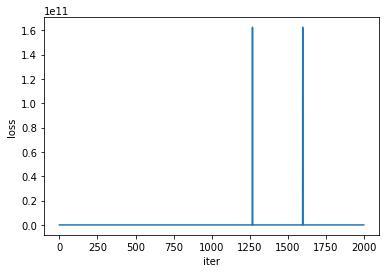

[array([1.01078277]), array([2.00797841])]


In [146]:
if __name__ == '__main__':
    observed_r, predicted_r, imputed_e, observed_e, propensities = get_data()
    theta1,theta2,theta,loss_list = SGD(predicted_r, imputed_e, observed_e, propensities, step_size = 0.0001)
    print(theta)